# Beta estimation

In this chapter, we introduce you to an important concept in financial economics: the exposure of an individual stock to changes in the market portfolio. According to the Capital Asset Pricing Model (CAPM) of [Sharpe1964](https://doi.org/10.1111/j.1540-6261.1964.tb02865.x), [Lintner1965](https://doi.org/10.1111/j.1540-6261.1965.tb02930.x), and [Mossin1966](https://doi.org/10.2307/1910098), cross-sectional variation in expected asset returns should be a function of the covariance between the excess return of the asset and the excess return on the market portfolio. The regression coefficient of market returns on excess returns is usually called the market beta. We show an estimation procedure for the market betas. We do not go into details about the foundations of market beta but simply refer to any treatment of the [CAPM](https://en.wikipedia.org/wiki/Capital_asset_pricing_model) for further information. Instead, we provide details about all the functions that we use to compute the results. In particular, we leverage useful computational concepts: rolling-window estimation and parallelization. 

## Estimating beta using monthly returns

The estimation procedure is based on a rolling-window estimation where we may use either monthly or daily returns and different window lengths. First, let us start with loading the monthly data from our `SQLite`-database introduced in the previous chapters 2-3.

In [2]:
import pandas as pd
import sqlite3
# Read sqlite query results into a pandas DataFrame
tidy_finance = sqlite3.connect("D:/Tidy/tidyfinance.sqlite")
crsp_monthly = pd.read_sql_query("SELECT * from crsp_monthly", tidy_finance)
factors_ff_monthly = pd.read_sql_query("SELECT * from factors_ff_monthly", tidy_finance)

In [3]:
crsp_monthly=pd.merge(crsp_monthly,factors_ff_monthly,left_on='month',right_on='month')[['permno', 'month', 'industry', 'ret_excess', 'mkt_excess']]
crsp_monthly['month']=pd.to_datetime(crsp_monthly['month'])
crsp_monthly['permno']=crsp_monthly['permno'].astype(int)

To estimate the CAPM equation 
$$
r_{i, t} - r_{f, t} = \alpha_i + \beta_i(r_{m, t}-r_{f,t})+\varepsilon_{i, t}
$$
we regress excess stock returns `ret_excess` on excess returns of the market portfolio `mkt_excess`. 
`statsmodels.api` provides a simple solution to estimate (linear) models with the function `OLS()`. `OLS()` requires a formula as input that is specified in a compact symbolic form.  In addition to standard linear models, `OLS()` provides a lot of flexibility. You should check out the documentation for more information. To start, we restrict the data only to the time series of observations in CRSP that correspond to Apple’s stock (i.e., to `permno` 14593 for Apple) and compute $\alpha_i$ as well as $\beta_i$.

In [4]:
crsp_monthly_AAPL=crsp_monthly.loc[crsp_monthly.permno == 14593]

In [5]:
import statsmodels.api as sm
y=crsp_monthly_AAPL['ret_excess'].values
X=crsp_monthly_AAPL['mkt_excess'].values
X=sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     142.2
Date:                Thu, 11 Aug 2022   Prob (F-statistic):           7.07e-29
Time:                        22:28:07   Log-Likelihood:                 357.56
No. Observations:                 480   AIC:                            -711.1
Df Residuals:                     478   BIC:                            -702.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0105      0.005      1.978      0.0

`OLS()` returns an object of class `OLS` which contains all information we usually care about with linear models. `summary()` returns an overview of the estimated parameters. 

## Rolling-window estimation

After we estimated the regression coefficients on an example, we scale the estimation of  $\beta_i$ to a whole different level and perform rolling-window estimations for the entire CRSP sample. The following function implements the CAPM regression for a data frame (or a part thereof) containing at least `min_obs` observations to avoid huge fluctuations if the time series is too short. If the condition is violated, the function returns a missing value. 

In [6]:
def estimate_capm(data, min_obs = 1):
    if len(data) < min_obs:
        beta = float('NaN')
    else:
        y=data['ret_excess'].values
        X=data['mkt_excess'].values
        X=sm.add_constant(X)
        beta = sm.OLS(y, X).fit().params[1]
    return beta

In [7]:
def roll_capm_estimation(data,month=60,min_obs=48):
    res=pd.DataFrame(columns=['month','beta'])
    if len(data)< min_obs:
        beta=float('NaN')
        date=float('NaN')
        industry=float('NaN')
        temp=pd.DataFrame({'month':date,'beta':beta},index=[0])
        res=res.append(temp,ignore_index=True)
    elif len(data) >= min_obs and len(data) < month:
        num = len(data) - min_obs + 1
        for i in list(range(num)):
            beta=estimate_capm(data.iloc[0:min_obs+i,:])
            date=data.iloc[min_obs+i-1,:].month
            industry=data.iloc[min_obs+i-1,:].industry
            temp=pd.DataFrame({'month':date,'beta':beta},index=[0])
            res=res.append(temp,ignore_index=True)
    else:
        least=month-min_obs
        for i in list(range(least)):
            beta=estimate_capm(data.iloc[0:min_obs+i,:])
            date=data.iloc[min_obs+i-1,:].month
            industry=data.iloc[min_obs+i-1,:].industry
            temp=pd.DataFrame({'month':date,'beta':beta},index=[0])
            res=res.append(temp,ignore_index=True)
        mid=len(data)-month+1
        for i in list(range(mid)):
            beta=estimate_capm(data.iloc[0+i:month+i,:])
            date=data.iloc[month+i-1,:].month
            industry=data.iloc[month+i-1,:].industry
            temp=pd.DataFrame({'month':date,'beta':beta},index=[0])
            res=res.append(temp,ignore_index=True)
    return res

In [8]:
crsp_monthly_AAPL=crsp_monthly_AAPL.sort_values('month')
res=roll_capm_estimation(crsp_monthly_AAPL,60,48)
res

,month,beta
0,1984-12-01,2.048594
1,1985-01-01,1.903054
2,1985-02-01,1.884804
3,1985-03-01,1.894952
4,1985-04-01,1.897543
...,...,...
428,2020-08-01,1.211956
429,2020-09-01,1.241308
430,2020-10-01,1.269681
431,2020-11-01,1.201832


Before we attack the whole CRSP sample, let us focus on a couple of examples for well-known firms.
We take a total of 5 years of data and require at least 48 months with return data to compute our betas. 
Check out the exercises if you want ot compute beta for different time periods.

In [9]:
crsp_monthly_example=crsp_monthly.loc[(crsp_monthly.permno == 14593)|(crsp_monthly.permno == 10107)|(crsp_monthly.permno == 93436)|(crsp_monthly.permno == 17778)]
crsp_monthly_example=crsp_monthly_example.sort_values(['permno','month'])

In [10]:
beta_example=crsp_monthly_example.groupby('permno').apply(lambda x:roll_capm_estimation(x,60,48))

In [11]:
beta_example=beta_example.reset_index().drop(['level_1'],axis=1).sort_values(['permno','month'])

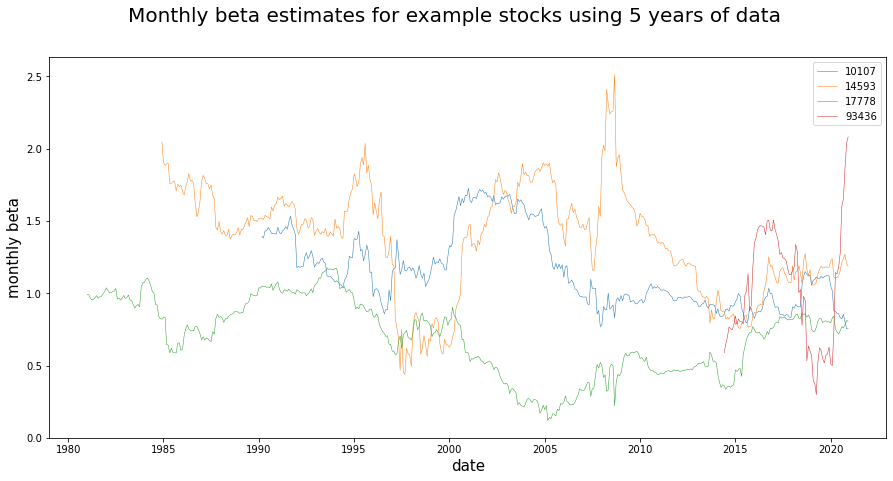

In [12]:
import matplotlib.pyplot as plt
permno=list(beta_example.permno.drop_duplicates())
fig, ax = plt.subplots(figsize = (15,7))
for ind in permno:
    ax.plot(beta_example[ beta_example["permno"] == ind ]['month'], beta_example[ beta_example["permno"] == ind ]['beta'], linewidth=0.5,label=ind)
fig.suptitle('Monthly beta estimates for example stocks using 5 years of data',fontsize=20)
ax.set_xlabel('date',fontsize=15)
ax.set_ylabel('monthly beta',fontsize=15)
ax.legend()
plt.show()

In [13]:
crsp_monthly=crsp_monthly.sort_values(['permno','month']).reset_index(drop=True)

## Parallelized rolling-window estimation

Even though we could now just apply the function using `groupby()` on the whole CRSP sample, we advise against doing it as it is computationally quite expensive. 
Remember that we have to perform rolling-window estimations across all stocks and time periods. 
However, this estimation problem is an ideal scenario to employ the power of parallelization. 
Parallelization means that we split the tasks which perform rolling-window estimations across different workers (or cores on your local machine). 

In [ ]:
# beta_monthly = crsp_monthly.groupby('permno').apply(lambda x:roll_capm_estimation(x,60,48))
# time 52min40s

In [14]:
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing

def temp_func(func, name, group):
    return func(group), name    
def applyParallel(dfGrouped, func):         
    retLst, top_index = zip(*Parallel(n_jobs=multiprocessing.cpu_count())(delayed(temp_func)(func, name, group) for name, group in dfGrouped))     
    return pd.concat(retLst, keys=top_index)


In [15]:
beta_monthly_p=applyParallel(crsp_monthly.groupby('permno'), roll_capm_estimation)

In [16]:
beta_monthly_p=beta_monthly_p.dropna()

In [17]:
beta_monthly_p=beta_monthly_p.reset_index().drop(['level_1'],axis=1).rename(columns={"level_0": "permno"})

## Comparing beta estimates

What is a typical value for stock betas? To get some feeling, we illustrate the dispersion of the estimated $\hat\beta_i$ across different industries and across time below. The first figure below shows that typical business models across industries imply different exposure to the general market economy. However, there are barely any firms that exhibit a negative exposure to the market factor.

In [18]:
beta_merge=pd.merge(beta_monthly_p,crsp_monthly,left_on=['permno','month'],right_on=['permno','month'],how='inner')

In [19]:
beta_ind=beta_merge.groupby(['industry','permno']).mean()['beta']

In [20]:
all_data=beta_ind.unstack()

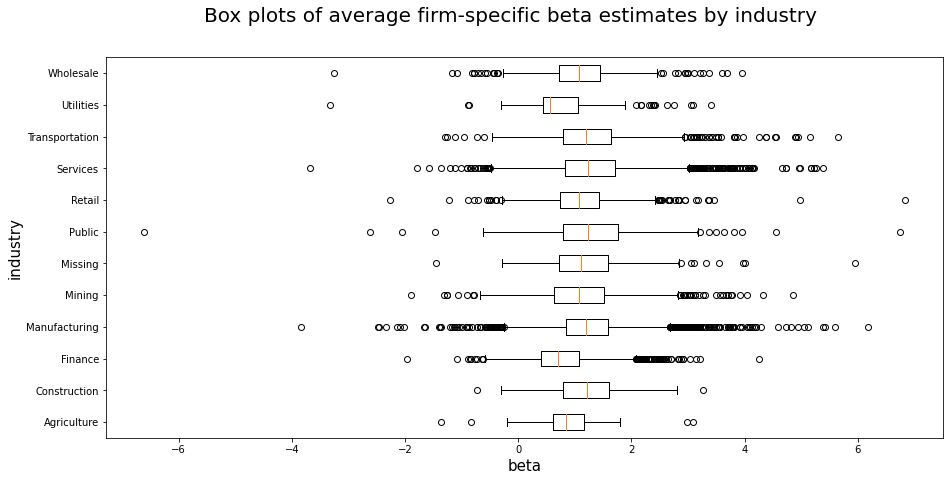

In [21]:
fig, ax = plt.subplots(figsize = (15,7))
ax.boxplot([all_data.loc[ind].dropna().values for ind in list(all_data.index)],labels=list(all_data.index),vert=False)
fig.suptitle('Box plots of average firm-specific beta estimates by industry',fontsize=20)
ax.set_xlabel('beta',fontsize=15)
ax.set_ylabel('industry',fontsize=15)
plt.show()

Next, we illustrate the time-variation in the cross-section of estimated betas. The figure below shows the monthly deciles of estimated betas (based on monthly data) and indicates an interesting pattern: First, betas seem to vary over time in the sense that during some periods, there is a clear trend across all deciles. Second, the sample exhibits periods where the dispersion across stocks increases in the sense that the lower decile decreases and the upper decile increases, which indicates that for some stocks the correlation with the market increases while for others it decreases. Note also here: stocks with negative betas are an extremely rare exception.

In [22]:
import numpy as np
beta_monthly_q=beta_monthly_p.groupby('month').quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])['beta']

In [23]:
beta_monthly_q=beta_monthly_q.unstack()

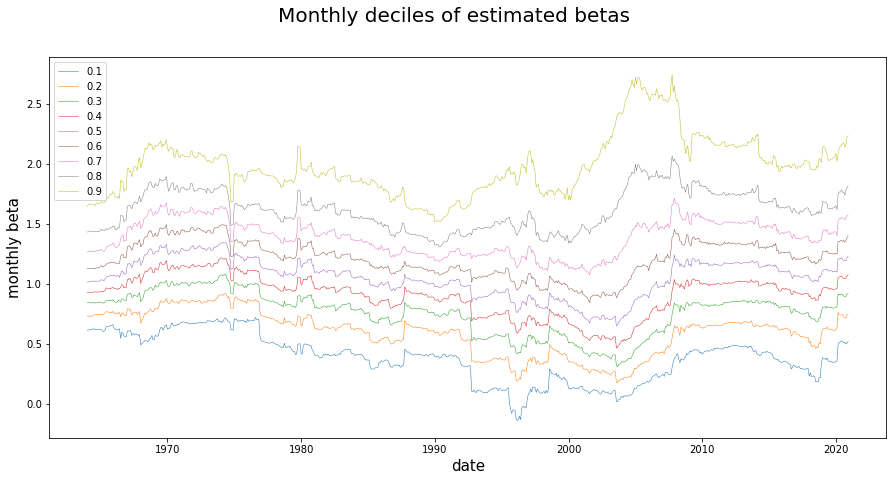

In [24]:
fig, ax = plt.subplots(figsize = (15,7))
ax.plot(beta_monthly_q, linewidth=0.5,label=beta_monthly_q.columns)
fig.suptitle('Monthly deciles of estimated betas',fontsize=20)
ax.set_xlabel('date',fontsize=15)
ax.set_ylabel('monthly beta',fontsize=15)
ax.legend()
plt.show()


In [25]:
beta_monthly_p=beta_monthly_p.rename(columns={'beta':'beta_monthly'})


In [26]:
beta_monthly_p.to_sql('beta',tidy_finance,if_exists='replace')